In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis (EDA)

In [3]:
fake_job_postings = pd.read_csv('fake_job_postings.csv')

In [4]:
fake_job_postings.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [5]:
fake_job_postings.shape

(17880, 18)

## 1. Drop/Replace Null values (remove data that cannot be analyzed)

In [6]:
fake_job_postings = fake_job_postings[-fake_job_postings.description.isna()]

In [7]:
fake_job_postings.requirements = fake_job_postings.requirements.fillna(' ')
fake_job_postings.benefits = fake_job_postings.benefits.fillna(' ')

In [8]:
fake_job_postings['text'] = fake_job_postings['requirements'] + ". " + fake_job_postings['description'] + ". " + fake_job_postings['benefits'] 

from langdetect import detect

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

fake_job_postings['is_english'] = fake_job_postings['text'].apply(is_english)
fake_job_postings = fake_job_postings[(fake_job_postings.is_english == True)]

In [9]:
fake_job_postings.isnull().sum()

job_id                     0
title                      0
location                 336
department             11455
salary_range           14880
company_profile         3282
description                0
requirements               0
benefits                   0
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3416
required_experience     6977
required_education      8027
industry                4841
function                6403
fraudulent                 0
text                       0
is_english                 0
dtype: int64

## 2. Data Transformation/Adding Variables

In [10]:
fake_job_postings[['country', 'state', 'city']] = (
    fake_job_postings['location']
    .fillna('blank')
    .str.split(',', expand=True)
    .iloc[:, :3]
)
fake_job_postings['country'] = fake_job_postings['country'].str.strip()
fake_job_postings['state'] = fake_job_postings['state'].str.strip()
fake_job_postings['city'] = fake_job_postings['city'].str.strip()

In [12]:
def factorize_top_n(dataframe, column_names, n):

    for column_name in column_names:
        value_counts = dataframe[column_name].value_counts(normalize=True)
        top_n_categories = value_counts.head(n).index
        dataframe[column_name+'_cat'] = dataframe[column_name].apply(
            lambda x: x if x in top_n_categories else 'Other'
        ).astype('category')
    
    return dataframe

In [13]:
def calculate_fraudulent_means(dataframe, column_name):
    fraudulent_stats = dataframe.groupby(column_name).agg(
        fraudulent_mean=('fraudulent', 'mean'),
        count=('fraudulent', 'size')
    ).reset_index()
    fraudulent_stats = fraudulent_stats.sort_values(by='count', ascending=False)
    return fraudulent_stats

In [14]:
features = ['industry', 'department', 'salary_range', 'function', 
            'employment_type', 'required_experience', 'required_education']

fake_job_postings = factorize_top_n(fake_job_postings, features, 20)

In [15]:
fake_job_postings = factorize_top_n(fake_job_postings,['country'], 2)

In [16]:
def ratio(df, column_name):

    ratio = (
        df[df.fraudulent == 1].groupby(column_name)[column_name].count() /
        df[df.fraudulent == 0].groupby(column_name)[column_name].count()
    )
    return ratio

In [17]:
edu_ratio = ratio(fake_job_postings, 'required_education_cat')
employment_ratio = ratio(fake_job_postings, 'employment_type_cat')
exp_ratio = ratio(fake_job_postings, 'required_experience_cat')

fake_job_postings['edu_ratio'] = fake_job_postings['required_education_cat'].map(edu_ratio)
fake_job_postings['employment_ratio'] = fake_job_postings['employment_type_cat'].map(employment_ratio)
fake_job_postings['exp_ratio'] = fake_job_postings['required_experience_cat'].map(exp_ratio)

In [18]:
fake_job_postings[['title', 'company_profile', 'description', 'requirements',
                   'benefits', 'required_experience', 'required_education', 'function']] = (
    fake_job_postings[['title', 'company_profile', 'description', 'requirements',
                       'benefits', 'required_experience', 'required_education', 'function']]
    .fillna(" ")  
)
fake_job_postings['text'] =  fake_job_postings['title'] + ' ' + fake_job_postings['company_profile'] + ' ' + \
        fake_job_postings['description'] + ' ' + fake_job_postings['requirements'] + ' ' + fake_job_postings['benefits'] + ' ' + \
        fake_job_postings['required_experience'] + ' ' + fake_job_postings['required_education'] + ' ' + fake_job_postings['function']

### Plot of Features: 
**See the character count of the given columns: 'title', 'company_profile', 'description', 'requirements', 'benefits', 'text'**

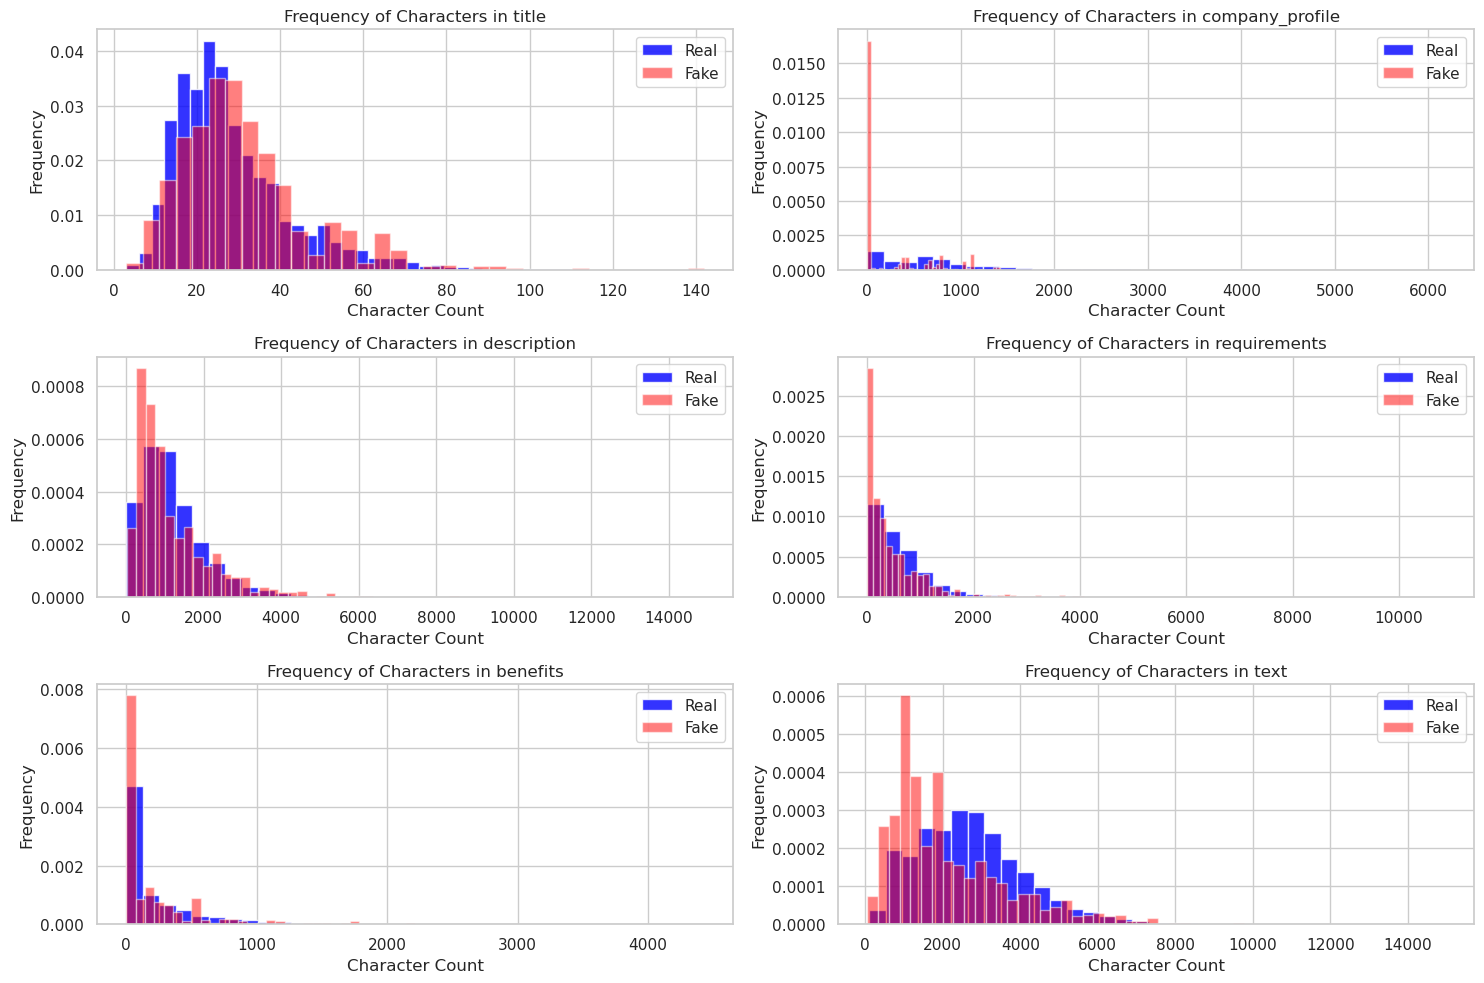

In [19]:
iii = ['title','company_profile','description','requirements','benefits','text']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))  

axes = axes.flatten()

for idx, i in enumerate(iii):
    fake_job_postings['character_count'] = fake_job_postings[i].apply(len)

    axes[idx].hist(fake_job_postings[fake_job_postings.fraudulent == 0].character_count, bins=35, 
                   color='blue', label='Real', alpha=0.8, density=True)
    axes[idx].hist(fake_job_postings[fake_job_postings.fraudulent == 1].character_count, bins=35, 
                   color='red', label='Fake', alpha=0.5, density=True)

    axes[idx].set_title(f'Frequency of Characters in {i}')
    axes[idx].set_xlabel('Character Count')
    axes[idx].set_ylabel('Frequency')
    axes[idx].legend()

plt.tight_layout()

plt.show()

**If a job posting is fake, the character count will around 500-600 characters. If a job posting is real, the character count will be around 2000 characters.**

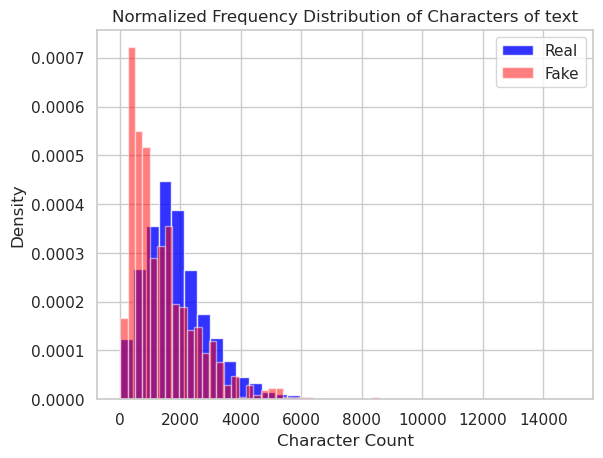

In [20]:
fake_job_postings['character_count'] = (
    fake_job_postings['company_profile'] + fake_job_postings['description']
).apply(len)

fake_job_postings[fake_job_postings.fraudulent == 0].character_count.plot(
    bins=35, kind='hist', color='blue', label='Real', alpha=0.8, density=True
)
fake_job_postings[fake_job_postings.fraudulent == 1].character_count.plot(
    bins=35, kind='hist', color='red', label='Fake', alpha=0.5, density=True
)

plt.legend()
plt.title(f'Normalized Frequency Distribution of Characters of {i}')
plt.xlabel("Character Count")
plt.ylabel("Density")
plt.show()

In [20]:
clean_data = fake_job_postings[['fraudulent','telecommuting','has_company_logo','has_questions',
                                'country_cat','edu_ratio','employment_ratio', 'exp_ratio', 'text',
                                'character_count']]

In [21]:
clean_data.isnull().sum()

fraudulent          0
telecommuting       0
has_company_logo    0
has_questions       0
country_cat         0
edu_ratio           0
employment_ratio    0
exp_ratio           0
text                0
character_count     0
dtype: int64

In [22]:
clean_data.head()

,fraudulent,telecommuting,has_company_logo,has_questions,country_cat,edu_ratio,employment_ratio,exp_ratio,text,character_count
0,0,0,1,0,US,0.059111,0.074697,0.027322,"Marketing Intern We're Food52, and we've creat...",1790
1,0,0,1,0,Other,0.059111,0.044217,0.057143,Customer Service - Cloud Video Production 90 S...,3363
2,0,0,1,0,US,0.059111,0.074697,0.066005,Commissioning Machinery Assistant (CMA) Valor ...,1234
3,0,0,1,0,US,0.019784,0.044217,0.030245,Account Executive - Washington DC Our passion ...,3214
4,0,0,1,1,US,0.019784,0.044217,0.030245,Bill Review Manager SpotSource Solutions LLC i...,3148


# NLP

## Bag of Words (BoW)

In [23]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

import nltk
import re

### Text Preprocessing:

**Prepares raw text data for analysis or modeling by text preprocessing.**

- **Downloading NLP Resources:**

    - The code uses NLTK (Natural Language Toolkit), a popular library for text processing.

    - Downloads two resources:

        - `punkt`: A tokenizer model to split text into words.

        - `stopwords`: A list of commonly used words in English (like "the", "is", "and"), which are often irrelevant for tasks like sentiment analysis or topic modeling.

- **Loading and Cleaning Text Data:**

    - Missing values in the text column are replaced with empty strings (""). This ensures that the text-processing pipeline handles missing entries gracefully.

- **Tokenization and Case Normalization:**

    - Each text entry is split into words using tokenization.

    - All tokens (words) are converted to lowercase to make the text case-insensitive (e.g., "Data" and "data" are treated the same).

- **Removing Noise:**

    - `Stopword Removal`: Common words that don't add significant meaning (like "and", "the", "is") are excluded.

    - `Regex Filtering`: Ensures only alphabetic tokens are kept, removing numbers, special characters, and punctuation.

- **Creating a Processed Token Column:**

    - The cleaned and filtered tokens are stored as a new column (processed_tokens) in the clean_data DataFrame.

    - Each entry in this column is a list of relevant tokens (e.g., ['data', 'analysis', 'important'] for a given text).

In [24]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')

english_stopped = set(stopwords.words('english'))

text = clean_data.text.fillna("")  

processed_tokens = [
    [t.lower() for t in word_tokenize(row) if re.match(r'^[a-z]+$', t.lower()) and t.lower() not in english_stopped]
    for row in text
]

clean_data['processed_tokens'] = processed_tokens

[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [25]:
clean_data['processed_tokens']

0        [marketing, intern, created, groundbreaking, c...
1        [customer, service, cloud, video, production, ...
2        [commissioning, machinery, assistant, cma, val...
3        [account, executive, washington, dc, passion, ...
4        [bill, review, manager, spotsource, solutions,...
                               ...                        
17875    [account, director, distribution, vend, lookin...
17876    [payroll, accountant, weblinc, platform, servi...
17877    [project, cost, control, staff, engineer, cost...
17878    [graphic, designer, nemsia, studios, looking, ...
17879    [web, application, developers, vend, looking, ...
Name: processed_tokens, Length: 17740, dtype: object

**Prepares text data for analysis by:**

- Flattening token lists. (all_tokens)

- Lemmatizing the tokens to their base forms.

- Creating a frequency distribution of the lemmatized tokens using a bag-of-words model.

- Finally, it prints the top 10 most frequent words along with their counts.

In [26]:
import nltk
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()
all_tokens = [token for row in clean_data.processed_tokens for token in row]
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in all_tokens]
bow = Counter(lemmatized)
print(Counter.most_common(bow, 10))

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[('experience', 36827), ('work', 36535), ('team', 36192), ('service', 29611), ('company', 28157), ('customer', 27860), ('business', 23775), ('client', 19860), ('product', 19568), ('new', 17872)]


**Cell Below:**
- Converts raw text into numerical feature vectors based on a fixed vocabulary (most_common_words).

- These vectors can be used as input for models like logistic regression, SVMs, or neural networks for tasks like text classification, clustering, etc.

In [27]:
def calculate_row_bow(text, wordnet_lemmatizer, most_common_words, stop_words):
    tokens = word_tokenize(text)
    lower_tokens = [t.lower() for t in tokens]
    text_only_alphabets = [t for t in lower_tokens if t.isalpha()]
    filtered_tokens = [t for t in text_only_alphabets if t not in stop_words]
    lemmatized_ = [wordnet_lemmatizer.lemmatize(token) for token in filtered_tokens]
    bow = Counter(lemmatized_)

    return [bow.get(word, 0) for word in most_common_words]

**Cell Below:**
- Creates a Bag-of-Words representation of the text data, limited to the top top_n most frequent words across the dataset. 

- The resulting bow_top10 column contains feature vectors for each row, which can be used as input for machine learning models or statistical analysis.

In [28]:
top_n = 10
global_bow = Counter(lemmatized)
most_common_words = [word for word, _ in global_bow.most_common(top_n)]
stop_words = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()

clean_data['bow_top10'] = clean_data['text'].fillna(" ").apply(
    lambda x: calculate_row_bow(x, wordnet_lemmatizer, most_common_words, stop_words)
)

**Cell Below:**
- Generates a Bag-of-Words feature representation of text data based on the top 5 most frequent words across the dataset.

In [29]:
top_n = 5
global_bow = Counter(lemmatized)
most_common_words = [word for word, _ in global_bow.most_common(top_n)]
stop_words = stopwords.words('english')
wordnet_lemmatizer = WordNetLemmatizer()

clean_data['bow_top5'] = clean_data['text'].fillna(" ").apply(
    lambda x: calculate_row_bow(x, wordnet_lemmatizer, most_common_words, stop_words)
)

In [30]:
clean_data['bow_top10']

0          [1, 2, 2, 0, 1, 0, 1, 0, 0, 4]
1          [7, 3, 5, 9, 2, 6, 4, 4, 1, 0]
2          [1, 2, 0, 5, 3, 0, 0, 3, 0, 1]
3          [6, 3, 4, 1, 1, 3, 9, 0, 0, 1]
4          [2, 2, 1, 6, 2, 2, 1, 1, 0, 1]
                       ...               
17875    [1, 11, 5, 0, 5, 11, 3, 0, 1, 3]
17876      [7, 5, 1, 1, 3, 3, 0, 3, 0, 0]
17877      [1, 2, 2, 1, 2, 0, 1, 1, 0, 0]
17878      [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
17879      [1, 8, 7, 0, 0, 3, 1, 0, 2, 5]
Name: bow_top10, Length: 17740, dtype: object

**Overall Workflow**

- Tokenized Text to Strings:

    - Converts tokenized text in processed_tokens into strings for each document.

- Count Vectorization:

    - Transforms the text data into a document-term matrix, where each document is represented by the frequency of words in the vocabulary.

- DataFrame Creation:

    - Converts the matrix into a more interpretable Pandas DataFrame for analysis, visualization, or modeling.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [32]:
processed_text = clean_data['processed_tokens'].apply(lambda tokens: ' '.join(tokens))

count_vectorizer = CountVectorizer(stop_words='english')
count_ = count_vectorizer.fit_transform(processed_text.values)
count_df = pd.DataFrame(count_.toarray(), columns=count_vectorizer.get_feature_names_out())

# Feature Combinations & Labels

## TF-IDF

In [33]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=1)
tfidf_ = tfidf_vectorizer.fit_transform(processed_text.values)
tfidf_df = pd.DataFrame(tfidf_.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

## Feature Combination

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD

numerical_features = clean_data[['telecommuting','has_company_logo','has_questions','edu_ratio','employment_ratio','exp_ratio','character_count']]
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(numerical_features)

categorical_features = clean_data[['country_cat']]
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_features = encoder.fit_transform(categorical_features)

processed_other_features = np.hstack([scaled_numerical_features, encoded_categorical_features])

In [35]:
print(encoder.categories_)

[array(['GB', 'Other', 'US'], dtype=object)]


In [36]:
processed_other_features = np.delete(processed_other_features, -3, axis=1)

#### (1) TF-IDF Feature With "Bag of Words" Top 10

In [40]:
svd = TruncatedSVD(n_components=300)  
reduced_tfidf_vectors = svd.fit_transform(tfidf_)
combined_features_1 = np.hstack([reduced_tfidf_vectors, processed_other_features])

In [41]:
bow_features = pd.DataFrame(clean_data['bow_top10'].tolist())
bow_features_array = bow_features.to_numpy()
combined_features_1 = np.hstack([combined_features_1, bow_features_array])

#### (2) Count Feature with "Bag of Words" Top 10

In [42]:
svd = TruncatedSVD(n_components=300)  
reduced_count_vectors = svd.fit_transform(count_)
combined_features_2 = np.hstack([reduced_count_vectors, processed_other_features])

In [43]:
bow_features = pd.DataFrame(clean_data['bow_top10'].tolist())
bow_features_array = bow_features.to_numpy()
combined_features_2 = np.hstack([combined_features_2, bow_features_array])

#### (3) TF-IDF Feature with "Bag of Words" Top 5

In [44]:
svd = TruncatedSVD(n_components=300)  
reduced_tfidf_vectors = svd.fit_transform(tfidf_)
combined_features_3 = np.hstack([reduced_tfidf_vectors, processed_other_features])

In [45]:
bow_features = pd.DataFrame(clean_data['bow_top5'].tolist())
bow_features_array = bow_features.to_numpy()
combined_features_3 = np.hstack([combined_features_3, bow_features_array])

#### (4) Count feature with Bag of Words Top 5

In [56]:
svd = TruncatedSVD(n_components=300) 
reduced_count_vectors = svd.fit_transform(count_)
combined_features_4 = np.hstack([reduced_count_vectors, processed_other_features])

In [57]:
bow_features = pd.DataFrame(clean_data['bow_top5'].tolist())
bow_features_array = bow_features.to_numpy()
combined_features_4 = np.hstack([combined_features_4, bow_features_array])

## Labels For Train-Test Split

In [48]:
labels = np.array(clean_data['fraudulent'])

# Feature Selection

In [88]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [58]:
from xgboost import XGBClassifier

combined_features = [combined_features_1,combined_features_2,combined_features_3,combined_features_4]

xgb_model = XGBClassifier(eval_metric='auc',alpha=0.01,max_depth=5,min_child_weight=3,n_estimators=400)
for i in range(4):
    features = combined_features[i]
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42,)
    
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)

    print('Feature Combo',i+1)
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("AUC Score:", roc_auc_score(y_test, y_pred))
    print('--------------------------------------------------------')

Feature Combo 1
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3366
           1       0.83      0.51      0.63       182

    accuracy                           0.97      3548
   macro avg       0.90      0.75      0.81      3548
weighted avg       0.97      0.97      0.97      3548

Accuracy: 0.9692784667418264
F1 Score: 0.6279863481228669
AUC Score: 0.7499249116896176
--------------------------------------------------------
Feature Combo 2
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3366
           1       0.95      0.67      0.79       182

    accuracy                           0.98      3548
   macro avg       0.97      0.83      0.89      3548
weighted avg       0.98      0.98      0.98      3548

Accuracy: 0.9813979706877114
F1 Score: 0.7870967741935484
AUC Score: 0.8342735695676872
--------------------------------------------------------
Feature Combo 3
        

**We choose Feature Combination 4: Count Feature with Bag of Words Top 5**

# Model Selection

In [60]:
features = combined_features_4
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

**We tried LogisticRegression, SGDClassifier, RandomForestClassifier and XGBClassifier.**

**XGBClassifier delivers the best results, so we conclude that the XG Boost Classifier is the best model for predicting fake job postings.**

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3366
           1       0.80      0.61      0.69       182

    accuracy                           0.97      3548
   macro avg       0.89      0.80      0.84      3548
weighted avg       0.97      0.97      0.97      3548

Accuracy: 0.9723788049605412
Recall: 0.6098901098901099
F1 Score: 0.69375
AUC Score: 0.8009343597578892


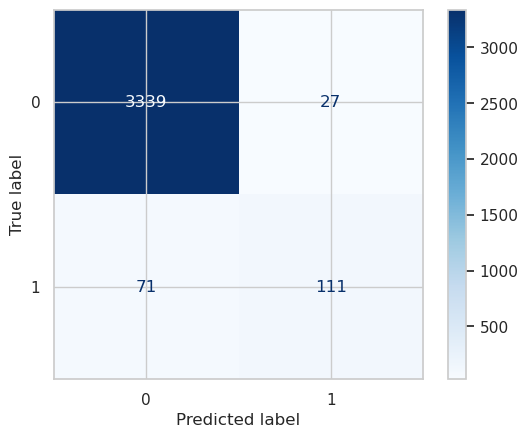

In [92]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues') 
plt.show()

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3366
           1       0.78      0.60      0.68       182

    accuracy                           0.97      3548
   macro avg       0.88      0.79      0.83      3548
weighted avg       0.97      0.97      0.97      3548

Accuracy: 0.9709695603156708
Recall: 0.5989010989010989
F1 Score: 0.6791277258566978
AUC Score: 0.7949942214648097


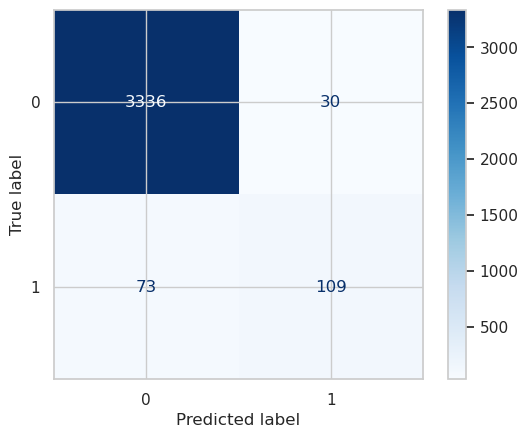

In [93]:
from sklearn.linear_model import SGDClassifier

model = SGDClassifier(loss='log_loss',  
                      random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues') 
plt.show()

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3366
           1       1.00      0.40      0.57       182

    accuracy                           0.97      3548
   macro avg       0.98      0.70      0.78      3548
weighted avg       0.97      0.97      0.96      3548

Accuracy: 0.9689966178128523
Recall: 0.3956043956043956
F1 Score: 0.5669291338582677
AUC Score: 0.6978021978021978


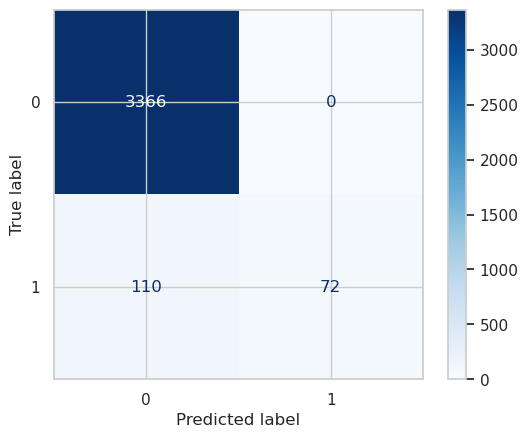

In [94]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues') 
plt.show()

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3366
           1       0.94      0.73      0.82       182

    accuracy                           0.98      3548
   macro avg       0.96      0.86      0.91      3548
weighted avg       0.98      0.98      0.98      3548

Accuracy: 0.983934611048478
Recall: 0.7307692307692307
F1 Score: 0.8235294117647058
AUC Score: 0.8641962612550849


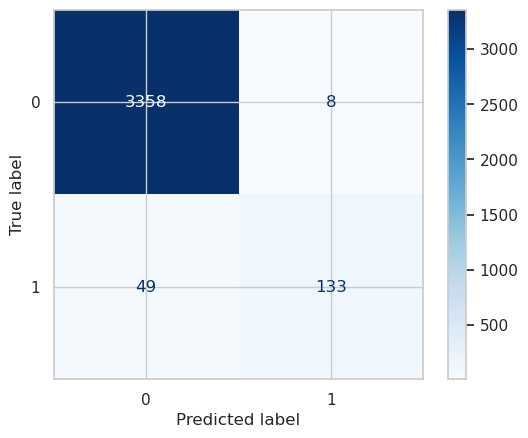

In [95]:
model = XGBClassifier(eval_metric='auc',alpha=0.05,max_depth=5,min_child_weight=3,n_estimators=400)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues') 
plt.show()

# Innovations of Our Project:
- Feature Engineering
- Feature Selection
- Developing ratios: Add quantified ratio variables: required_education, employment_type, required_experience.

- Numeric: 'fraudulent','telecommuting','has_company_logo','has_questions', 'edu_ratio', 'country_cat','edu_ratio','employment_ratio', 'exp_ratio', 'text', 'character_count'
- 'country_cat' is a categorical variable, so turned it into a dummy variable using 'onehotencoding'. Removed GB as a category in the dummy variable to avoid multicollinearity.